In [73]:
import numpy as np
import pandas as pd
from collections import defaultdict
from math import radians, sin, cos, sqrt, atan2
from helper_functions import *
import re
from collections import Counter
from scipy.stats import zscore

from sklearn.model_selection import GroupKFold
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
import joblib

#### Computing scores for Origin-Return transformations

In [62]:
gt = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/gt/anomalous_temporal.csv')
gt

,agent,started_at,finished_at,time_segment,day_of_week,day_type
0,1194166,2025-04-01 00:09:50+09:00,2025-04-01 00:43:10+09:00,0-5.59,1,weekday
1,1515449,2025-04-01 00:12:40+09:00,2025-04-01 01:01:00+09:00,0-5.59,1,weekday
2,1194166,2025-04-01 12:43:30+09:00,2025-04-01 13:16:50+09:00,9-13.59,1,weekday
3,1515449,2025-04-01 13:01:20+09:00,2025-04-01 13:49:40+09:00,9-13.59,1,weekday
4,1515449,2025-04-02 01:50:00+09:00,2025-04-02 02:38:20+09:00,0-5.59,2,weekday
...,...,...,...,...,...,...
1432,1515449,2025-05-31 10:15:40+09:00,2025-05-31 11:04:00+09:00,9-13.59,5,weekend
1433,943170,2025-05-31 10:33:10+09:00,2025-05-31 11:21:20+09:00,9-13.59,5,weekend
1434,1194166,2025-05-31 10:46:10+09:00,2025-05-31 11:19:30+09:00,9-13.59,5,weekend
1435,1515449,2025-05-31 23:04:20+09:00,2025-05-31 23:52:40+09:00,21.30-23.59,5,weekend


In [64]:
train = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/10k/ore/or_train.csv')
test = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/10k/ore/or_test.csv')
gt = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/gt/anomalous_temporal.csv')
ground_truth = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/gt/anomalous_temporal.csv')

test['started_at']  = pd.to_datetime(test['started_at'])
test['finished_at'] = pd.to_datetime(test['finished_at'])

train['started_at']  = pd.to_datetime(train['started_at'])
train['finished_at'] = pd.to_datetime(train['finished_at'])

gt['started_at'] = pd.to_datetime(gt['started_at']) 
gt['started_at'] = gt['started_at'].dt.tz_convert('Asia/Tokyo')
gt['finished_at'] = pd.to_datetime(gt['finished_at']) 
gt['finished_at'] = gt['finished_at'].dt.tz_convert('Asia/Tokyo')

# adding ground truth
train['label'] = 0
test['label'] = 0

for agent, gt_agent in gt.groupby('agent'):
    agent_mask = test['agent'] == agent

    if not agent_mask.any():
        continue

    for _, row in gt_agent.iterrows():
        anomaly_start_time = row['started_at']
        anomaly_end_time   = row['finished_at']

        overlap_mask = (
            agent_mask &
            (test['started_at'] < anomaly_end_time) &
            (test['finished_at'] > anomaly_start_time)
        )

        test.loc[overlap_mask, 'label'] = 1


In [70]:
def add_features(df):
    df = df.copy()
    
    df['start_minute'] = df['started_at'].dt.hour * 60 + df['started_at'].dt.minute
    
    def _len_trans(x):
        if isinstance(x, (list, tuple)):
            return len(x)
        try:
            return len(eval(x))
        except:
            return np.nan
    
    df['len_trans'] = df['transformation'].apply(_len_trans)
    df['speed_imbalance'] = (df['avg_speed_first_half'] - df['avg_speed_second_half']).abs()
    
    return df

# def supervised_anomaly_scoring(test_df):
#     test = add_features(test_df)

#     feature_cols = [
#         'duration_min',
#         'start_minute',
#         'len_trans',
#         'max_distance_from_home',
#         'avg_speed_first_half',
#         'avg_speed_second_half',
#         'speed_imbalance'
#     ]

#     X = test[feature_cols].fillna(0.0)
#     y = test['label'].values
#     groups = test['agent'].values

#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)

#     gkf = GroupKFold(n_splits=5)

#     preds = np.zeros(len(test))
#     model = GradientBoostingClassifier()

#     for train_idx, valid_idx in gkf.split(X, y, groups):
#         X_tr, X_val = X[train_idx], X[valid_idx]
#         y_tr = y[train_idx]

#         model.fit(X_tr, y_tr)
#         preds[valid_idx] = model.predict_proba(X_val)[:, 1]

#     test['anomaly_score_row'] = preds

#     ap = average_precision_score(y, preds)
#     print(f"Out-of-fold Average Precision = {ap:.4f}")

#     agent_scores = (
#         test.groupby('agent')['anomaly_score_row']
#             .max()
#             .reset_index(name='agent_anomaly_score')
#     )

#     return agent_scores, test, model



def supervised_anomaly_scoring(test_df):
    test = add_features(test_df)

    feature_cols = [
        'duration_min',
        'start_minute',
        'len_trans',
        'max_distance_from_home',
        'avg_speed_first_half',
        'avg_speed_second_half',
        'speed_imbalance'
    ]

    X = test[feature_cols].fillna(0.0)
    y = test['label'].values
    groups = test['agent'].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    gkf = GroupKFold(n_splits=5)

    preds = np.zeros(len(test))
    model = GradientBoostingClassifier()

    model.fit(X, y)

    preds[:] = model.predict_proba(X)[:, 1]

    test['anomaly_score_row'] = preds

    ap = average_precision_score(y, preds)
    print(f"Out-of-fold Average Precision = {ap:.4f}")

    agent_scores = (
        test.groupby('agent')['anomaly_score_row']
            .max()
            .reset_index(name='agent_anomaly_score')
    )

    return agent_scores, test, model, scaler, feature_cols


In [66]:
appended_df = pd.concat([train, test], ignore_index=True)

In [71]:
agent_scores, test_scored, model, scaler, feature_cols = supervised_anomaly_scoring(appended_df)

Out-of-fold Average Precision = 0.2437


In [74]:
joblib.dump(
    {
        "model": model,
        "scaler": scaler,
        "feature_cols": feature_cols,
    },
    "gb_anomaly_bundle.joblib"
)

['gb_anomaly_bundle.joblib']

In [55]:
agent_scores.to_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/10k/ore.csv', index=False)

In [68]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
import matplotlib.pyplot as plt

def plot_agent_level_pr_roc(agent_scores, gt):
    scores = agent_scores.copy()

    # Create ground truth binary label
    scores['label'] = scores['agent'].isin(gt['agent']).astype(int)

    y_true = scores['label'].values
    y_score = scores['agent_anomaly_score'].values

    # ---------- Precision Recall ----------
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    # ---------- ROC ----------
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # ---------- Plot ----------
    plt.figure(figsize=(12,5))

    # PR Curve
    plt.subplot(1,2,1)
    plt.plot(recall, precision, linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve (AP = {ap:.4f})")
    plt.grid(alpha=0.3)

    # ROC Curve
    plt.subplot(1,2,2)
    plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Average Precision: {ap:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    return scores


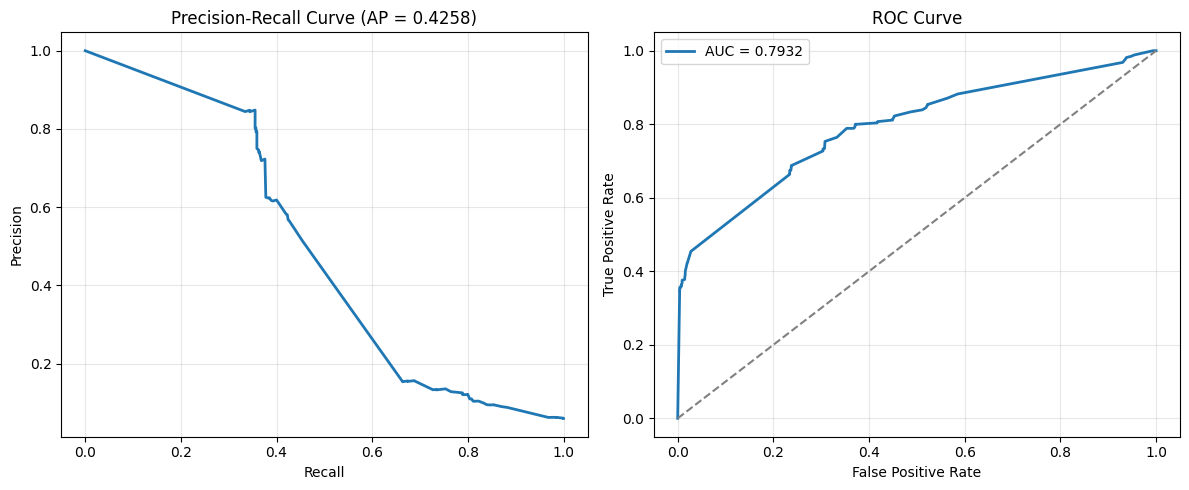

Average Precision: 0.4258
ROC-AUC: 0.7932


In [69]:
evaluated = plot_agent_level_pr_roc(agent_scores, gt)

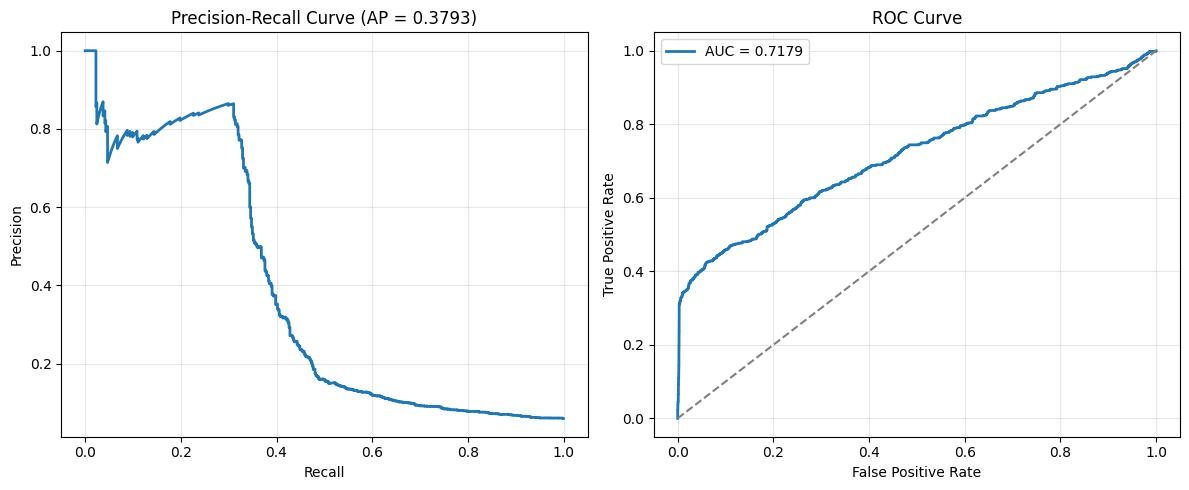

Average Precision: 0.3793
ROC-AUC: 0.7179


In [23]:
evaluated = plot_agent_level_pr_roc(agent_scores, gt)

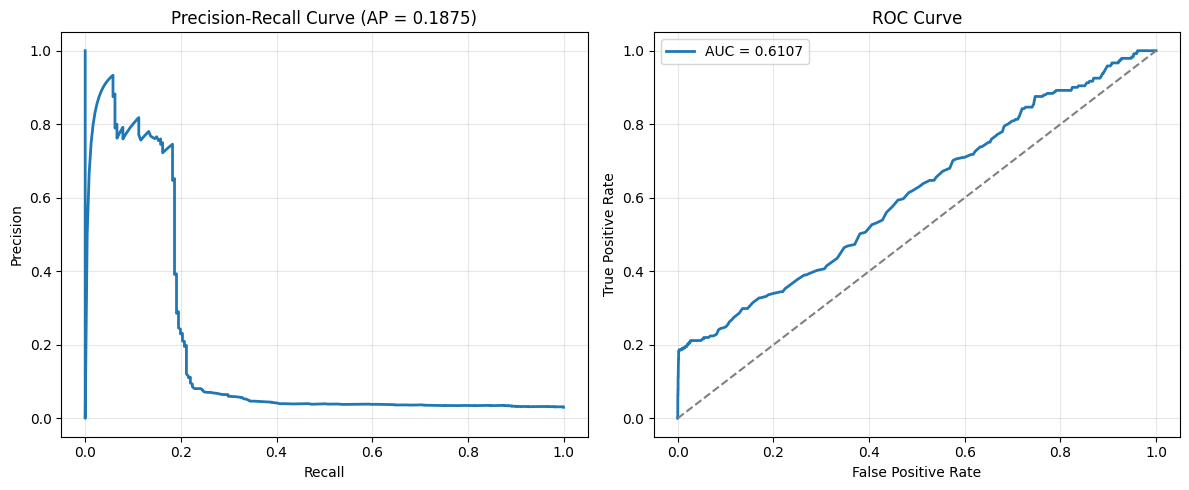

Average Precision: 0.1875
ROC-AUC: 0.6107


In [134]:
evaluated = plot_agent_level_pr_roc(agent_scores, gt)

In [123]:
# Analyze top 10% highest anomaly scores
TOP_FRACTION = 0.01
num_agents = len(agent_scores)
top_n = max(1, int(np.ceil(num_agents * TOP_FRACTION)))

print(f"Total agents: {num_agents}")
print(f"Selecting top {TOP_FRACTION:.0%} => {top_n} agents with highest composite scores")

# Select top agents by composite anomaly score
anomaly_df_sorted = agent_scores.sort_values('agent_anomaly_score', ascending=False)
top_agents = anomaly_df_sorted.head(top_n).copy()

# Check how many are in ground truth
top_agents['is_ground_truth'] = top_agents['agent'].isin(ground_truth['agent'])
num_gt_in_top = top_agents['is_ground_truth'].sum()

print(f"Ground truth anomalies within top {TOP_FRACTION:.0%}: {num_gt_in_top}")
print(f"Percentage of top {TOP_FRACTION:.0%} that are ground truth: {num_gt_in_top / top_n:.2%}")
#print(f"Share of all ground truth anomalies captured: {num_gt_in_top / agent_scores['is_anomaly'].sum():.2%}")

top_agents[['agent', 'agent_anomaly_score', 'is_ground_truth']].head(20)


Total agents: 7953
Selecting top 1% => 80 agents with highest composite scores
Ground truth anomalies within top 1%: 53
Percentage of top 1% that are ground truth: 66.25%


,agent,agent_anomaly_score,is_ground_truth
7342,736011,1.0,True
1220,127678,1.0,True
7673,771653,1.0,False
3289,332749,1.0,False
5416,541287,1.0,True
5608,562025,1.0,True
2060,212229,1.0,True
2954,300767,1.0,True
2956,300980,1.0,True
7643,767556,1.0,True


In [139]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

def calculate_supervised_anomaly_scores(train_df, test_df):
    def get_features(df, profiles=None, is_train_set=False):
        # 1. Basic Preprocessing
        df = df.copy()
        df['start_min'] = pd.to_datetime(df['started_at']).dt.hour * 60 + pd.to_datetime(df['started_at']).dt.minute
        df['trans_tuple'] = df['transformation'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
        df['trans_len'] = df['transformation'].apply(len)
        df['speed_diff'] = (df['avg_speed_first_half'] - df['avg_speed_second_half']).abs()

        # 2. Build or Apply Agent Profiles
        if is_train_set:
            # Create profiles from the training data only
            profiles = df.groupby('agent').agg(
                avg_dur=('duration_min', 'mean'),
                avg_start=('start_min', 'mean'),
                max_dist_hist=('max_distance_from_home', 'max'),
                known_trans=('trans_tuple', lambda x: set(x)),
                known_pois=('dominant_poi', lambda x: set(x))
            ).reset_index()
            return profiles

        # 3. Join profiles to the dataframe to calculate "Deltas"
        data = df.merge(profiles, on='agent', how='left')
        
        # 4. Feature Engineering: Deviations from their own "Normal"
        features = pd.DataFrame()
        features['agent'] = data['agent'] # Keep for grouping later
        
        # Temporal Deltas
        features['delta_duration'] = (data['duration_min'] - data['avg_dur']).abs()
        features['delta_start'] = (data['start_min'] - data['avg_start']).abs()
        
        # Structural Novelty (Binary/Categorical)
        #features['is_new_transformation'] = data.apply(lambda r: 1 if r['trans_tuple'] not in r['known_trans'] else 0, axis=1)
        #features['is_new_poi'] = data.apply(lambda r: 1 if r['dominant_poi'] not in r['known_pois'] else 0, axis=1)
        
        # Numerical magnitude
        features['dist_vs_max'] = data['max_distance_from_home'] / (data['max_dist_hist'] + 1e-5)
        features['speed_imbalance'] = data['speed_diff']
        features['max_distance'] = data['max_distance_from_home']
        features['trans_len'] = data['trans_len']
        
        return features, data['label']

    # --- Execution ---
    
    # 1. Learn "Normal" from Train Data
    agent_profiles = get_features(train_df, is_train_set=True)
    
    # 2. Extract features for Test Data based on Train Profiles
    X, y = get_features(test_df, profiles=agent_profiles, is_train_set=False)
    
    # Prepare X for ML (drop agent ID)
    X_ml = X.drop(columns=['agent']).fillna(0)
    
    # 3. Train Model (Using Cross-Validation to get scores for all test rows)
    # We use a Classifier because we have labels (0 and 1)
    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    
    # To get a score for every row without over-fitting, use Out-of-Fold predictions
    skf = StratifiedKFold(n_splits=5)
    test_df['row_score'] = 0.0
    
    for train_idx, val_idx in skf.split(X_ml, y):
        X_train_fold, y_train_fold = X_ml.iloc[train_idx], y.iloc[train_idx]
        X_val_fold = X_ml.iloc[val_idx]
        
        clf.fit(X_train_fold, y_train_fold)
        # Probability of being class 1 is our anomaly score
        test_df.loc[val_idx, 'row_score'] = clf.predict_proba(X_val_fold)[:, 1]

    # 4. Aggregate to Agent Level
    agent_scores = test_df.groupby('agent').agg(
        mean_anomaly_prob=('row_score', 'mean'),
        max_anomaly_prob=('row_score', 'max'),
        total_anomalies_detected=('label', 'sum') # Ground truth count
    ).reset_index()
    
    # Final Ranking Score
    agent_scores['final_score'] = (agent_scores['mean_anomaly_prob'] * 0.4) + (agent_scores['max_anomaly_prob'] * 0.6)
    
    return agent_scores.sort_values(by='final_score', ascending=False)

In [140]:
result_df = calculate_supervised_anomaly_scores(train, test)

In [ ]:
agent_scores